In [190]:
#Module 호출

import requests
import pandas as pd
from matplotlib import legend
import matplotlib.pyplot as plt

In [191]:
#공매도 잔고 및 개별종목 시세 Crawling을 위한 종목별 KR코드 확인을 위한 종목마스터 데이터 Crawling

url = 'http://data.krx.co.kr/comm/bldAttendant/getJsonData.cmd'
payload = {
      'bld': 'dbms/MDC/STAT/standard/MDCSTAT01901',
      'mktId': 'ALL',
  }
raw = requests.post(url, data=payload)
rst = raw.json()['OutBlock_1']
df_master = pd.DataFrame.from_dict(rst)

In [192]:
#공매도 잔고 Crawling 함수
#input 6자리 종목코드, 시작일, 종료일
#Source: Short.krx.co.kr / KRX 개별종목공매도잔고[33001]

def short_blance_data(ticker='096770',start_date=None,end_date=None):
    url = 'http://data.krx.co.kr/comm/bldAttendant/getJsonData.cmd'
    stock = df_master[df_master['ISU_SRT_CD']==ticker] if len(df_master[df_master['ISU_ABBRV']==ticker.upper()])<1 else df_master[df_master['ISU_ABBRV']==ticker.upper()]
    if len(stock) > 0:
        data = {
            'bld': 'dbms/MDC/STAT/srt/MDCSTAT30502',
            'searchType': '2',
            'mktTpCd': '1',
            'isuCd': '{}'.format(stock['ISU_CD'].iloc[0]),
            'strtDd': start_date,
            'endDd': end_date,
            'share': 1,
            'money': 1,
            'csvxls_isNo': 'false'
        }
        raw = requests.post(url,  data=data)
        rst = raw.json()['OutBlock_1']
        df = pd.DataFrame.from_dict(rst)
        return df
    else:
        return 'No matched result'

In [193]:
#해당종목 주가 Crawling 함수
#input 6자리 종목코드, 시작일, 종료일
#Source: Marketdata.krx.co.kr / 개별종목시세추이[12003]

def stock_price_data(ticker='096770',start_date=None,end_date=None):
    url = 'http://data.krx.co.kr/comm/bldAttendant/getJsonData.cmd'
    stock = df_master[df_master['ISU_SRT_CD']==ticker] if len(df_master[df_master['ISU_ABBRV']==ticker.upper()])<1 else df_master[df_master['ISU_ABBRV']==ticker.upper()]
    if len(stock) > 0:
      payload2 = {
            'bld': 'dbms/MDC/STAT/standard/MDCSTAT01701',
            'isuCd': '{}'.format(stock['ISU_CD'].iloc[0]),
            'strtDd': start_date,
            'endDd': end_date,
            'adjStkPrc_check': 'Y',
            'adjStkPrc': 2,
            'share': 1,
            'money': 1,
            'csvxls_isNo': 'false'
        }
      raw = requests.post(url, data=payload2)
      rst = raw.json()['output']
      df_price = pd.DataFrame.from_dict(rst)
      return df_price
    else:
      return 'No matched result'

In [194]:
#Crawling 데이터 저장을 위한 빈 DataFrame 자료형 선언

df = pd.DataFrame()
df_price = pd.DataFrame()

#Crawling 함수 호출을 통한 데이터 확보

df = short_blance_data('096770', 20220101,20231231)
df_price = stock_price_data('096770', 20220101,20231231)

#Crawling 함수 통해 확보한 Data Cleansing

df01 = pd.DataFrame()
df01['Date'] = pd.to_datetime(df['RPT_DUTY_OCCR_DD'])
df01['Short Blance'] = df['BAL_QTY'].str.replace(',','').astype(float)

df02 = pd.DataFrame()
df02['Date'] = pd.to_datetime(df_price['TRD_DD'])
df02['Price'] = (df_price['MKTCAP'].str.replace(',','').astype(float))/(df_price['LIST_SHRS'].str.replace(',','').astype(float))

#데이터 병합(시세추이, 공매도잔고)

df1 = pd.DataFrame()
df1 = pd.merge(df01, df02, on='Date')

#DataFrame 정렬
df1.set_index('Date',inplace=True)
df1.sort_index(inplace=True, ascending=True)

In [195]:
#전략 실행을 위한 포지션 구축 함수 생성

def short_blance_strategy(data):

  data['Position'] = [0] * len(data)
  for i in range(1, len(data)):
      if data['Short Blance'][i]/data['Short Blance'][i-1] - 1 < -0.1: #공매도 잔고 금액(Short Blance)이 전일 대비 10% 감소하면 매수
          data['Position'][i] = 1
      elif data['Short Blance'][i]/data['Short Blance'][i-1] - 1 > 0.05: #공매도 잔고 금액(Shrt Blance)이 전일 대비 5% 증가하면 매도
          data['Position'][i] = 0

  return data

<ipython-input-195-ad0784416d88>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'][i] = 0
<ipython-input-195-ad0784416d88>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'][i] = 1


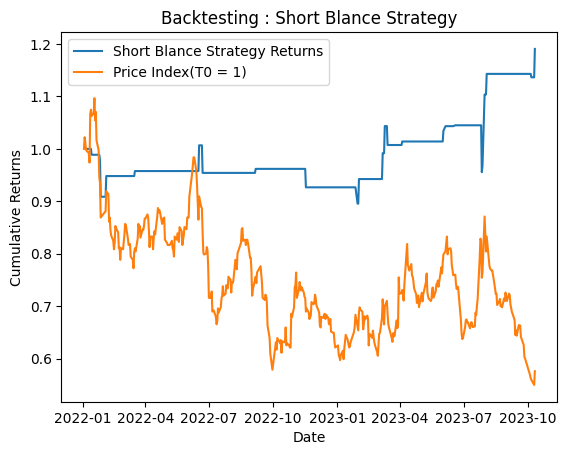

In [196]:
#전략 포지션 구축 자료 호출

result = short_blance_strategy(df1)

#Backtest를 위한 시점 조정

result['Position_2'] = result['Position'].shift(2) #공매도 잔고 금액은 발생시점과 공시시점 사이에 1영업일의 시차 발생. 잔고금액 변동 발생 이후 2일 이후 실행
result.drop(['Position'], axis=1, inplace=True)
result.rename(columns={'Position_2':'Position'}, inplace=True)

#수익률 산정

result['returns'] = result['Position'].shift(1) * (result['Price'] - result['Price'].shift(1)) / result['Price'].shift(1)
result['cumulative_returns'] = ((result['returns'] + 1).cumprod()) #-1로 하면 단순 수익률로 나옴

#Plotting

plt.plot(result.index,
         result['cumulative_returns'],label="Short Blance Strategy Returns")
plt.plot(result.index, result['Price']/result['Price'][0], label="Price Index(T0 = 1)")
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtesting : Short Blance Strategy')
plt.show()

In [197]:
#Summary
sharpe_ratio = result['returns'].mean() / result['returns'].std()
cumulative_returns = result['cumulative_returns']
max_drawdown = pd.DataFrame(cumulative_returns.cummax() - cumulative_returns).max()

print("Stock Price change " + str(result['Price'][-1]/result['Price'][0] -1))
print("Cumulative Returns " + str((result['cumulative_returns'][-1])-1))
print("Alpha " + str(((result['cumulative_returns'][-1])-1)-(result['Price'][-1]/result['Price'][0] -1)))
print("Sharpe Ratio " + str(sharpe_ratio))
print("Max Drawdown(MDD) "+ str(-max_drawdown.max()))
print("Count of Long Position " +str(len(result.loc[result['Position'] == 1])))

Stock Price change -0.4241935483870968
Cumulative Returns 0.19070561914138717
Alpha 0.614899167528484
Sharpe Ratio 0.04105324390269192
Max Drawdown(MDD) -0.11131550318224348
Count of Long Position 25


In [198]:
# 기간 2022 1월 1일 ~ 2023년 10월 11일까지 전략 결과

# 1
# 삼성전자
# Stock Price change -0.1323155216284987
# Cumulative Returns -0.008213344695935931
# Alpha 0.12410217693256276
# Sharpe Ratio -0.005806729984051486
# Max Drawdown(MDD) -0.0484010367787282
# Count of Long Position 15

# 2
# LG에너지솔루션
# Stock Price change -0.025742574257425765
# Cumulative Returns -0.05133184401779589
# Alpha -0.025589269760370126
# Sharpe Ratio -0.03651970167965819
# Max Drawdown(MDD) -0.07561858582863279
# Count of Long Position 7

# 3
# SK하이닉스
# Stock Price change -0.0723735408560311
# Cumulative Returns 0.08983176186828801
# Alpha 0.1622053027243191
# Sharpe Ratio 0.037977430227703314
# Max Drawdown(MDD) -0.0824003976182145
# Count of Long Position 28

# 4
# 삼성바이오로직스
# Stock Price change -0.2041712403951701
# Cumulative Returns -0.01323603730979217
# Alpha 0.19093520308537792
# Sharpe Ratio -0.06783292531151107
# Max Drawdown(MDD) -0.01323603730979217
# Count of Long Position 2

# 5
# POSCO 홀딩스
# Stock Price change 0.8107142857142857
# Cumulative Returns 0.13633957717898548
# Alpha -0.6743747085353002
# Sharpe Ratio 0.03724395097335447
# Max Drawdown(MDD) -0.11761966010256408
# Count of Long Position 43

# 6
# 현대차
# Stock Price change -0.10023752969121136
# Cumulative Returns 0.007217820612777093
# Alpha 0.10745535030398845
# Sharpe Ratio 0.007947253541265535
# Max Drawdown(MDD) -0.04862618784063888
# Count of Long Position 14

# 7
# LG화학
# Stock Price change -0.1618122977346278
# Cumulative Returns -0.05333123866628953
# Alpha 0.10848105906833827
# Sharpe Ratio -0.019967285855334638
# Max Drawdown(MDD) -0.10384845912199225
# Count of Long Position 29

# 8
# 삼성SDI
# Stock Price change -0.2138461538461538
# Cumulative Returns -0.10468265674387567
# Alpha 0.10916349710227813
# Sharpe Ratio -0.04360551912765376
# Max Drawdown(MDD) -0.11784115906540826
# Count of Long Position 17

# 9
# 기아차
# Stock Price change 0.02300242130750596
# Cumulative Returns 0.0802119271421271
# Alpha 0.057209505834621144
# Sharpe Ratio 0.047120533349198544
# Max Drawdown(MDD) -0.06513516420628296
# Count of Long Position 23

# 10
# 네이버
# Stock Price change -0.48670212765957444
# Cumulative Returns -0.009125757757493469
# Alpha 0.47757636990208097
# Sharpe Ratio -0.0005384157784848307
# Max Drawdown(MDD) -0.08812884868594695
# Count of Long Position 19

# 11
# 포스코퓨처엠
# Stock Price change 1.3763066202090593
# Cumulative Returns 0.2545480361314263
# Alpha -1.121758584077633
# Sharpe Ratio 0.09354273548305406
# Max Drawdown(MDD) -0.02132771625032226
# Count of Long Position 10

# 12
# KB금융
# Stock Price change 0.005424954792043302
# Cumulative Returns -0.0005268504799358364
# Alpha -0.005951805271979138
# Sharpe Ratio 0.0015081636628351057
# Max Drawdown(MDD) -0.0470355354054115
# Count of Long Position 18

# KB금융까지 KOSPI 시가총액 순위 / 이후 업종 다변화를 위해 중복 업종 기업 제외(현대모비스 등)

# 13
# 셀트리온
# Stock Price change -0.29017632241813607
# Cumulative Returns -0.014880952380952328
# Alpha 0.27529537003718374
# Sharpe Ratio -0.048056933133221263
# Max Drawdown(MDD) -0.014880952380952328
# Count of Long Position 1

# 14
# 삼성물산
# Stock Price change -0.09106382978723404
# Cumulative Returns -0.0974352667895767
# Alpha -0.006371437002342661
# Sharpe Ratio -0.07978340787138037
# Max Drawdown(MDD) -0.11056666445995145
# Count of Long Position 23

# 15
# 카카오
# Stock Price change -0.6275109170305677
# Cumulative Returns -0.006685862289106725
# Alpha 0.620825054741461
# Sharpe Ratio -0.0036244636664445893
# Max Drawdown(MDD) -0.07048373639896266
# Count of Long Position 11

# 16
# 신한지주
# Stock Price change -0.046979865771812124
# Cumulative Returns 0.030116091043426607
# Alpha 0.07709595681523873
# Sharpe Ratio 0.03248909808613086
# Max Drawdown(MDD) -0.02965957420002696
# Count of Long Position 16

# 17
# LG전자
# Stock Price change -0.23584229390681
# Cumulative Returns 0.15945391258968256
# Alpha 0.39529620649649255
# Sharpe Ratio 0.0645998815250979
# Max Drawdown(MDD) -0.06447792523934104
# Count of Long Position 32

# 18
# SK이노베이션
# Stock Price change -0.4241935483870968
# Cumulative Returns 0.19070561914138717
# Alpha 0.614899167528484
# Sharpe Ratio 0.04105324390269192
# Max Drawdown(MDD) -0.11131550318224348
# Count of Long Position 25